In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyedflib
import tensorflow as tf

import os
import sys
sys.path.append('..')

RECS_DIR = '../resources/datasets/mass/register'

from sleeprnn.data import utils
from sleeprnn.common import viz
from sleeprnn.nn import augmentations

viz.notebook_full_width()

Channel extracted: EEG C3-CLE
4000


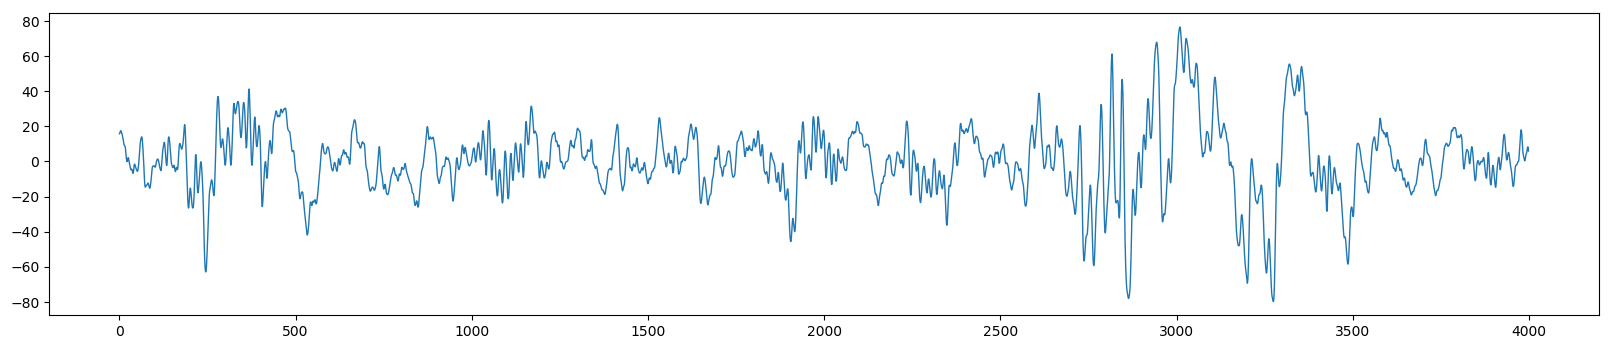

In [2]:
subject_id = 1
fs = 200
segment_size = 20

channel = 'EEG C3-CLE'
path_eeg_file = os.path.join(RECS_DIR, '01-02-%04d PSG.edf' % subject_id)

with pyedflib.EdfReader(path_eeg_file) as file:
    channel_names = file.getSignalLabels()
    channel_to_extract = channel_names.index(channel)
    signal = file.readSignal(channel_to_extract)
    fs_old = file.samplefrequency(channel_to_extract)
    # Check
    print('Channel extracted: %s' % file.getLabel(channel_to_extract))

# Particular fix for mass dataset:
fs_old_round = int(np.round(fs_old))
# Transform the original fs frequency with decimals to rounded version
signal = utils.resample_signal_linear(signal, fs_old=fs_old, fs_new=fs_old_round)
signal = utils.broad_filter(signal, fs_old_round)
signal = utils.resample_signal(signal, fs_old=fs_old_round, fs_new=fs)

input_size = int(segment_size * fs)
print(input_size)

label_dummy = np.zeros(input_size, dtype=np.int32)
label_dummy[1000:1400] = 1

page_idx = 700

start_sample = int(input_size * page_idx)
end_sample = start_sample + input_size
fig, ax = plt.subplots(1, 1, figsize=(20, 4), dpi=100)
ax.plot(signal[start_sample:end_sample], linewidth=1)
plt.show()

W1016 22:04:18.690292 140649454110528 deprecation_wrapper.py:119] From ../sleeprnn/nn/augmentations.py:113: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W1016 22:04:18.694077 140649454110528 deprecation_wrapper.py:119] From ../sleeprnn/nn/augmentations.py:118: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1016 22:04:18.809600 140649454110528 deprecation.py:323] From /home/ntapia/miniconda3/envs/tf/lib/python3.6/site-packages/tensorflow_probability/python/math/interpolation.py:126: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Tensor("elastic/apply_gaussian_kernel/strided_slice:0", shape=(81, 1, 1, 1), dtype=float32, device=/device:CPU:0)
Tensor("elastic/apply_gaussian_kernel/strided_slice_1:0", shape=(1, 4000, 1, 1), dtype=float32, device=/device:CPU:0)
(4000,) float32
(4000,) int32


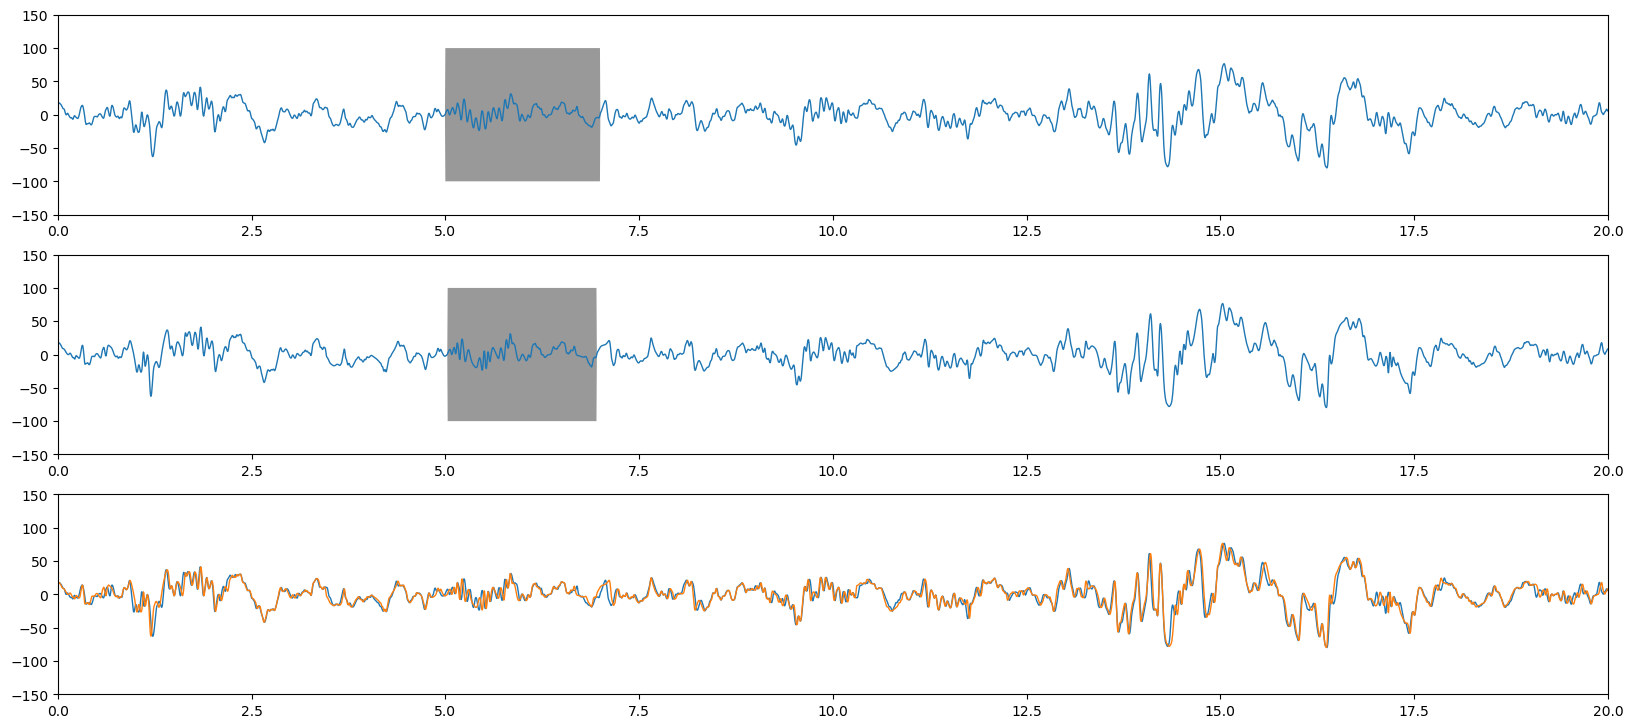

In [3]:
tf.reset_default_graph()

feat_ph = tf.placeholder(dtype=tf.float32, shape=[input_size])
label_ph = tf.placeholder(dtype=tf.int32, shape=[input_size])

new_feat, new_label = augmentations.elastic_1d_deformation(feat_ph, label_ph, fs, alpha=0.2, sigma=0.05)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    elastic_feat, elastic_label = sess.run([new_feat, new_label], feed_dict={feat_ph: signal[start_sample:end_sample], label_ph: label_dummy})
    
print(elastic_feat.shape, elastic_feat.dtype)
print(elastic_label.shape, elastic_label.dtype)

fig, ax = plt.subplots(3, 1, figsize=(20, 9), dpi=100)
time_axis = np.arange(input_size) / fs
ax[0].plot(time_axis, signal[start_sample:end_sample], linewidth=1)
ax[0].fill_between(time_axis, -100*label_dummy, 100*label_dummy, facecolor='k', alpha=0.4)
ax[0].set_ylim([-150, 150])
ax[0].set_xlim([0, segment_size])

ax[1].plot(time_axis, elastic_feat, linewidth=1)
ax[1].fill_between(time_axis, -100*elastic_label, 100*elastic_label, facecolor='k', alpha=0.4)
ax[1].set_ylim([-150, 150])
ax[1].set_xlim([0, segment_size])

ax[2].plot(time_axis, signal[start_sample:end_sample], linewidth=1)
ax[2].plot(time_axis, elastic_feat, linewidth=1)
ax[2].set_ylim([-150, 150])
ax[2].set_xlim([0, segment_size])

plt.show()